In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from problems.time_series.common import trend, seasonality, noise, windowed_dataset, plot_series

tf.__version__

import typing
from tensorflow import keras

if typing.TYPE_CHECKING:
    from keras.api._v2 import keras

In [2]:
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

2022-02-15 22:58:52.829845: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-15 22:58:52.833426: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-15 22:58:52.833553: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-15 22:58:52.834111: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Epoch 1/100


2022-02-15 22:58:56.674802: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8302
Could not load symbol cublasGetSmCountTarget from libcublas.so.11. Error: /usr/local/cuda/targets/x86_64-linux/lib/libcublas.so.11: undefined symbol: cublasGetSmCountTarget
2022-02-15 22:58:56.815371: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


31/31 [==============================] - 4s 10ms/step - loss: 71.9600 - mae: 72.4600 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 0s 5ms/step - loss: 70.7723 - mae: 71.2723 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 0s 5ms/step - loss: 69.3424 - mae: 69.8424 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 0s 5ms/step - loss: 67.7169 - mae: 68.2169 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 0s 4ms/step - loss: 65.9284 - mae: 66.4284 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 0s 4ms/step - loss: 63.9966 - mae: 64.4966 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 0s 4ms/step - loss: 61.9731 - mae: 62.4731 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 0s 4ms/step - loss: 59.8234 - mae: 60.3234 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 0s 4ms/step - loss: 57.5897 - mae: 58.0897 - lr: 2.511

(1e-08, 0.0001, 0.0, 30.0)

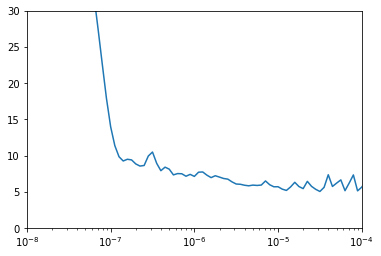

In [3]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),
    tf.keras.layers.Bidirectional(keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10 ** (epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [4]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9), metrics=["mae"])
history = model.fit(dataset, epochs=500)

5.513249


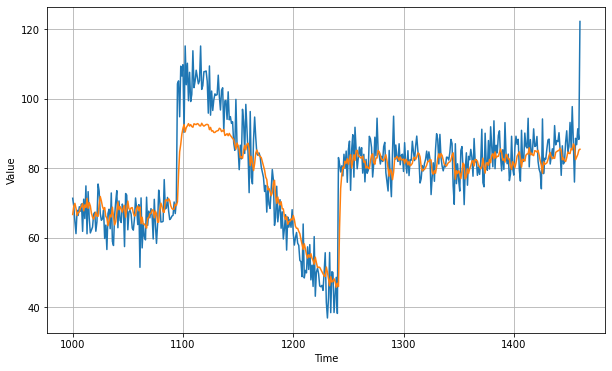

In [5]:
forecast = []
results = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time - window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

In [ ]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))
model.fit(dataset, epochs=100)

In [ ]:
forecast = []
results = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time - window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()